In [2]:
from svdunfold import SVDunfold
import svdunfold
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.signal import fftconvolve
from matplotlib.colors import LogNorm
from scipy import stats
import random
from scipy.interpolate import interp1d

In [3]:
nevents=100000
x0 = 1842 # M2
gamma0 = 6
x1 =  2047 # M1
gamma1 = 13.2
mu = 0
sigma=6.
gaussian_par=[mu,sigma]
cauchy_par_test_0=[x0,gamma0]
cauchy_par_test_1=[x1,gamma1]

cauchy_par_0=[x0-10,gamma0+1]
cauchy_par_1=[x1+20,gamma1-1]

x_min=1400
x_max=2500
x_nbins=100
b_min=1400
b_max=2500
b_nbins=100
nevents_test_0=nevents-40000
nevents_test_1=nevents+100000


def bins_and_centers(nbins, low, high):
    bins = np.linspace(low, high, nbins + 1)
    bin_centers = (bins + (bins[1] - bins[0]) / 2)[:-1]
    return bins, bin_centers


def add_smearing(x):
    smear = np.random.normal(gaussian_par[0],gaussian_par[1])
    return x + smear

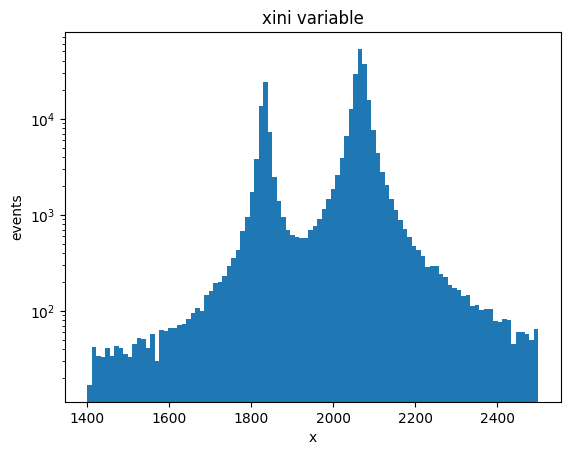

In [4]:
plt.figure(1)
xini_peak_0 = stats.cauchy.rvs(cauchy_par_0[0], cauchy_par_0[1], nevents_test_0) 
xini_peak_1 = stats.cauchy.rvs(cauchy_par_1[0], cauchy_par_1[1], nevents_test_1) 


xini_peak = np.append(xini_peak_0, xini_peak_1)

plt.hist(xini_peak, x_nbins, range=[x_min,x_max])
plt.title("xini variable")
plt.ylabel("events")
plt.xlabel("x")
plt.yscale("log")


(1400.0, 2500.0)

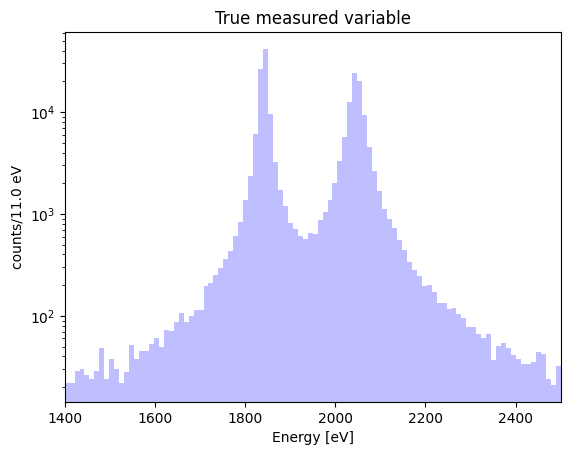

In [5]:
plt.figure(2)
xini_peak_test_0 = stats.cauchy.rvs(cauchy_par_test_0[0], cauchy_par_test_0[1], nevents) 
xini_peak_test_1 = stats.cauchy.rvs(cauchy_par_test_1[0], cauchy_par_test_1[1], nevents) 

xini_peak_test = np.append(xini_peak_test_0, xini_peak_test_1)

plt.hist(xini_peak_test, x_nbins, range=[x_min,x_max],histtype="stepfilled", color="blue", alpha=0.25)
plt.title("True measured variable")
plt.ylabel("counts/{} eV".format((x_max-x_min)/x_nbins))
plt.xlabel("Energy [eV]")
plt.yscale("log")
plt.xlim(x_min,x_max)

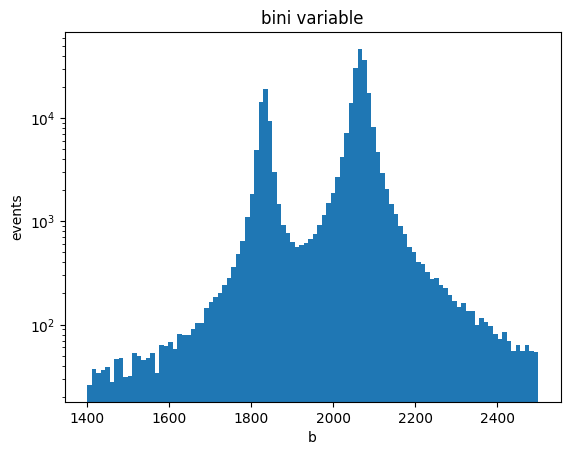

In [6]:
plt.figure(3)
b_ini_gen = []

for i in xini_peak:
    b_ini_gen.append(add_smearing(i))


plt.hist(b_ini_gen, x_nbins, range=[x_min,x_max])
plt.title("bini variable")
plt.ylabel("events")
plt.xlabel("b")
plt.yscale("log")


(1400.0, 2500.0)

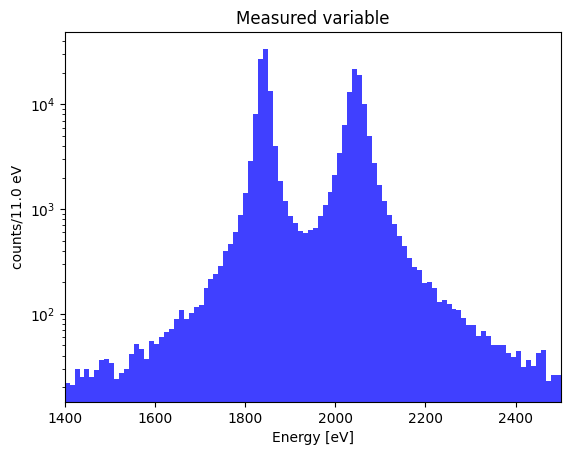

In [7]:

plt.figure(4)
b_test_gen = []

for i in xini_peak_test:
    b_test_gen.append(add_smearing(i))

plt.hist(b_test_gen, x_nbins, range=[x_min,x_max],histtype="stepfilled", color="blue", alpha=0.75)
plt.title("Measured variable")
plt.ylabel("counts/{} eV".format((x_max-x_min)/x_nbins))
plt.xlabel("Energy [eV]")
plt.yscale("log")
plt.xlim(x_min,x_max)



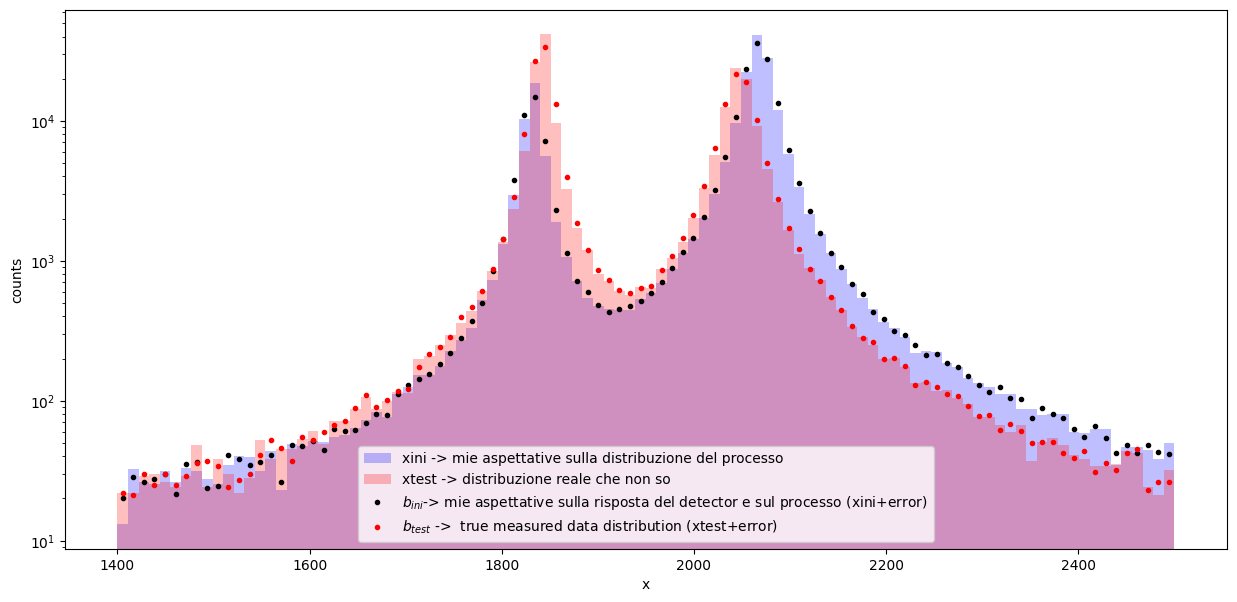

In [8]:
bins_x, bin_centers_x = bins_and_centers(x_nbins, x_min, x_max)
bins_b, bin_centers_b = bins_and_centers(b_nbins, b_min, b_max)

x_ini_gen = xini_peak
x_ini = np.histogram(x_ini_gen, bins_x)
x_test_gen = xini_peak_test
x_test = np.histogram(x_test_gen, bins_x)

scale_factor = len(x_test_gen)/len(x_ini_gen)

b_ini = np.histogram(b_ini_gen, bins_b)
b_test = np.histogram(b_test_gen, bins_b)


plt.figure(figsize=(15, 7))

plt.hist(x_ini_gen, density=False, bins=x_nbins, histtype="stepfilled", color="blue", 
         label="xini -> mie aspettative sulla distribuzione del processo", alpha=0.25, weights=scale_factor*np.ones(len(x_ini_gen)), range=[x_min, x_max])
plt.hist(x_test_gen, density=False, bins=x_nbins, histtype="stepfilled", color="red", label="xtest -> distribuzione reale che non so", alpha=0.25, range=[x_min, x_max])

binsb, bin_centers_b=bins_and_centers(b_nbins, b_min, b_max)

plt.plot(bin_centers_b, b_ini[0]*scale_factor, ".", color="black", label="$b_{ini}$-> mie aspettative sulla risposta del detector e sul processo (xini+error)")
plt.plot(bin_centers_b, b_test[0], ".", color="red", label="$b_{test}$ ->  true measured data distribution (xtest+error)")

plt.xlabel("x")
plt.ylabel("counts")
plt.yscale("log")
plt.legend()

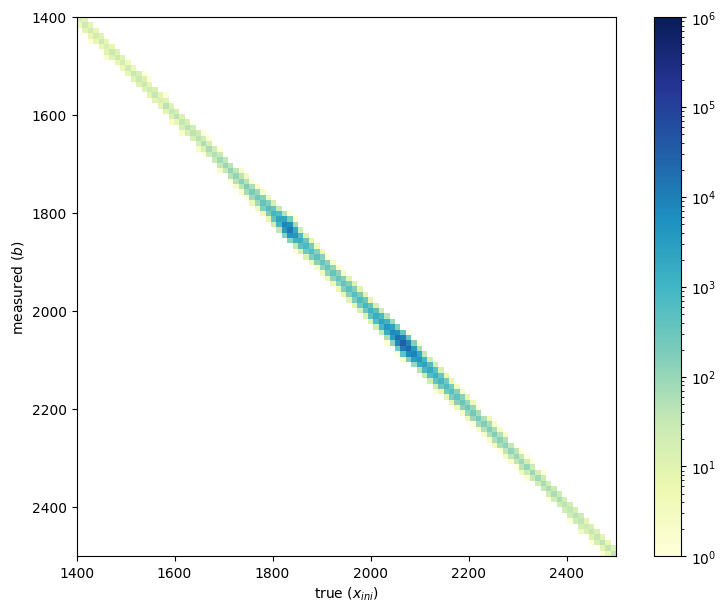

In [9]:
def generate_response_matrix(x_ini_gen, b_ini_gen, bins_x,bins_b):
    return np.histogram2d(x_ini_gen, b_ini_gen, bins=[bins_x,bins_b])

A_matrix=generate_response_matrix(x_ini_gen, b_ini_gen, bins_x,bins_b)[0].T
#la A_matrix è generata tramite la variabile che ho sulle mie aspettative del processo e la variabile delle mie aspettative sul processo e sul detector
plt.figure(figsize=(10, 7))
plt.imshow(A_matrix, norm=LogNorm(vmin=1, vmax=1e6), cmap="YlGnBu", extent=[bins_x[0], bins_x[-1],bins_b[-1],bins_b[0]])
plt.xlabel("true ($x_{ini}$)")
plt.ylabel("measured ($b$)")
plt.colorbar()

Text(0, 0.5, 'measured ($b_{ini}$)')

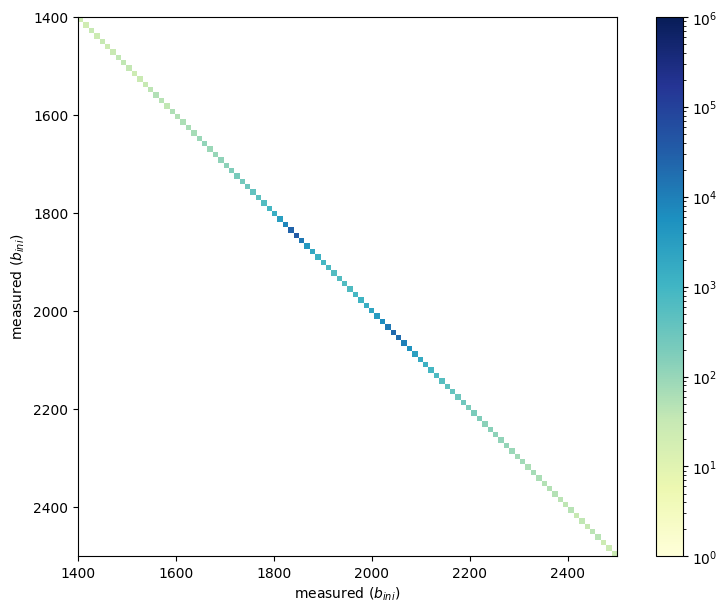

In [10]:
def diagonal_covariance(b, nb, b_min, b_max):
    data = np.histogram(b, bins=nb, range=(b_min, b_max))[0]
    B = np.zeros(shape=(nb,nb))
    std_dev = np.sqrt(data)
    for i in range(nb):
        B[i, i] = std_dev[i] * std_dev[i] #indipendent bin values
    return B

B = diagonal_covariance(b_test_gen, b_nbins, b_min, b_max)

plt.figure(figsize=(10, 7))

plt.imshow(B, norm=LogNorm(vmin=1, vmax=1e6), cmap="YlGnBu", extent=[bins_b[0], bins_b[-1],bins_b[-1],bins_b[0]])
plt.colorbar()
plt.xlabel("measured ($b_{ini}$)")
plt.ylabel("measured ($b_{ini}$)")

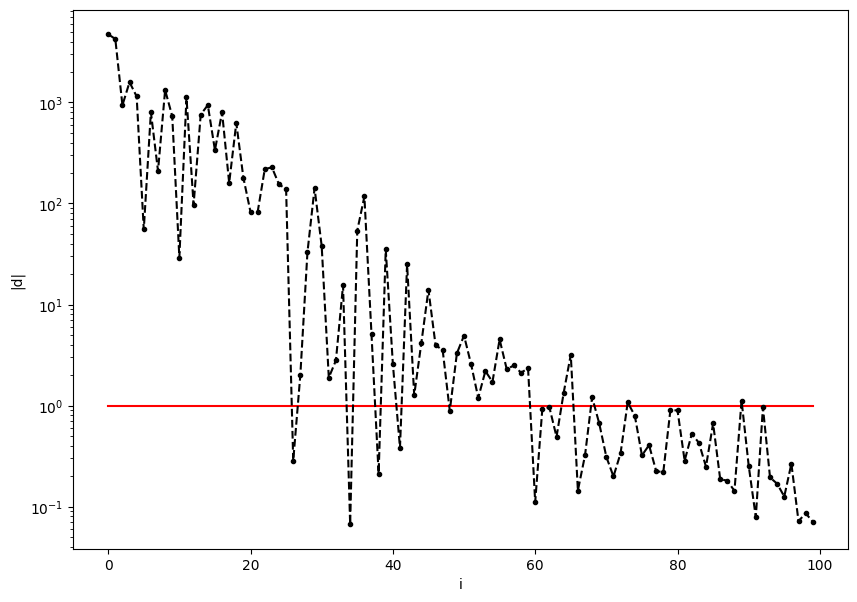

In [11]:
unfold = svdunfold.SVDunfold(x_ini, b_test, A_matrix, B, x_min,x_max,b_min,b_max, 0.0001)
#l'unfolding lo faccio con la variabile di dati che ottengo dalla misura btest e sulla sua B, dalla matrice A che è quella formulata tramite mie aspettative e dalle mie aspettative sulla distribuzione vera xini
unfold.pre_unfolding()

d = unfold.get_abs_d()

plt.figure(figsize=(10, 7))

plt.plot(np.arange(len(d)), np.ones(len(d)), "r-" )
plt.plot(np.arange(len(d)), d, "k.--")
plt.xlabel("i")
plt.ylabel("|d|")
plt.yscale("log")

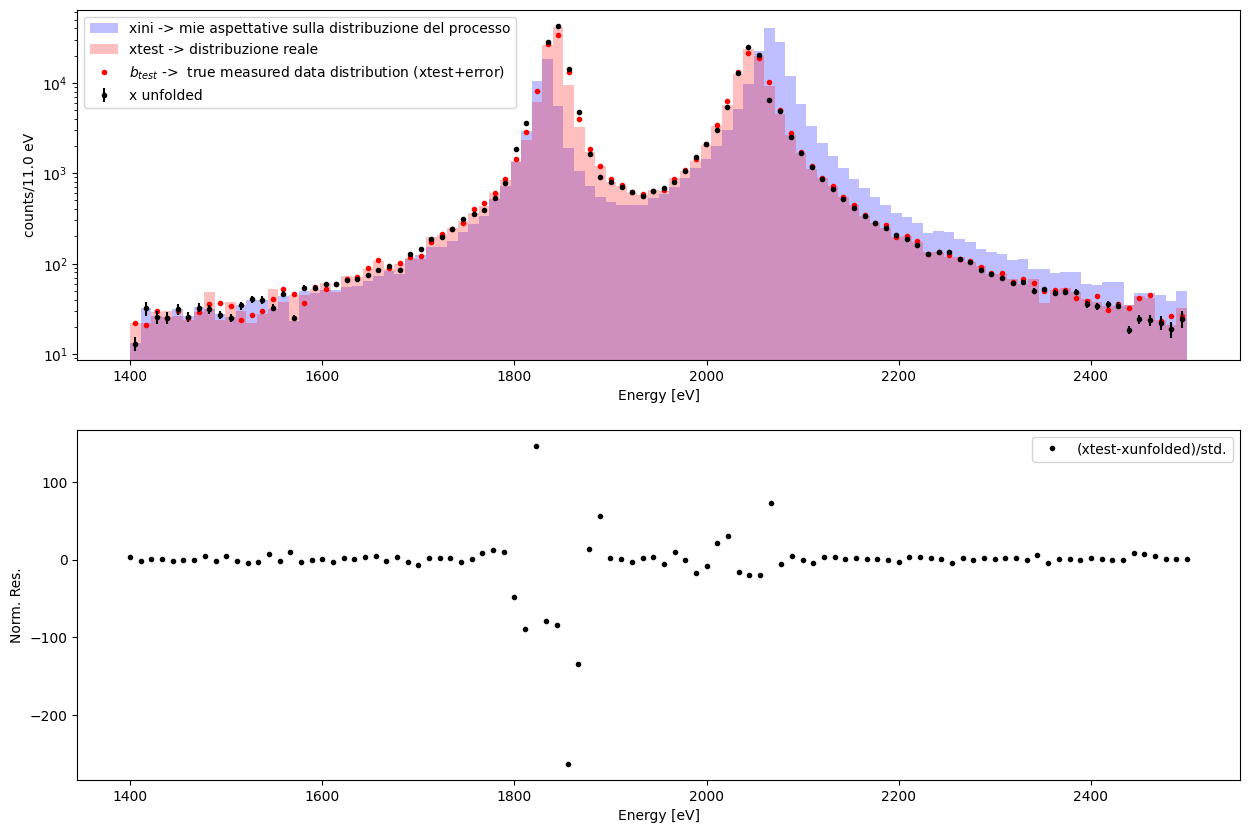

In [14]:
k=33
unfold.unfolding(k)  # Chiama il metodo unfolding
x = unfold.get_x_unfolded()
X = unfold.get_X_unfolded_covariance()

aa = np.linspace(x_min, x_max, x_nbins)
plt.subplots(2 , 1, figsize=(15, 10))
plt.subplot(2,1,1)
plt.hist(x_ini_gen, bins=x_nbins, range=[x_min, x_max], histtype="stepfilled", color="blue", alpha=0.25, label="xini -> mie aspettative sulla distribuzione del processo", weights=scale_factor*np.ones(len(x_ini_gen)))
plt.hist(x_test_gen, bins=x_nbins, range=[x_min, x_max], histtype="stepfilled", color="red", alpha=0.25, label="xtest -> distribuzione reale ")
bins_x, bin_centers_x = bins_and_centers(unfold._nx, x_min, x_max)
plt.plot(bin_centers_b, b_test[0], ".", color="red", label="$b_{test}$ ->  true measured data distribution (xtest+error)")


plt.errorbar(bin_centers_x, x, fmt="k.", yerr=np.sqrt(np.diagonal(X)), label="x unfolded")
plt.xlabel("Energy [eV]")
plt.ylabel("counts/{} eV".format((x_max-x_min)/x_nbins))
plt.legend()
plt.yscale("log")
plt.subplot(2,1,2)
plt.plot(aa,(x_test[0]-x)/np.sqrt(np.diag(X)), marker='.', linestyle="", color="black", label="(xtest-xunfolded)/std.")
plt.xlabel("Energy [eV]")
plt.legend()
plt.ylabel("Norm. Res.")
plt.savefig("{}eVRMS_binwidth{}_svdunfold.pdf".format(sigma, (x_max-x_min)/x_nbins))


Text(0, 0.5, 'unfolded x')

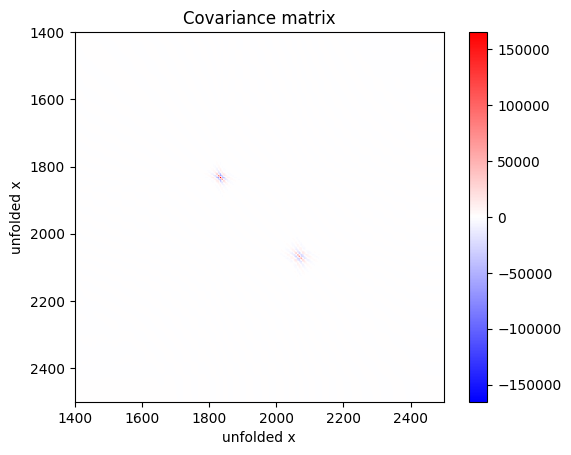

In [12]:
plt.imshow(X, cmap="bwr", vmin=-np.max(X), extent=[bins_b[0], bins_b[-1],bins_b[-1],bins_b[0]])
plt.colorbar()
plt.title("Covariance matrix")
plt.xlabel("unfolded x")
plt.ylabel("unfolded x")